In [1]:
import subprocess
import os
import sys
import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import scvelo as scv
scv.settings.verbosity=1

from pathlib import Path

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib inline

In [2]:
# Custom functions
sys.path.insert(1, '../..')
from utils import *

# scperturb package
sys.path.insert(1, '../../package/src/')
from scperturb import *

Things to potentially do:
- Run subsampling multiple times to estimate sensitivity
- Run E-tests per sample point to check when we lose significance
- Caputure sigma and delta separately to see what changes how

# Define data

In [109]:
h5_files = {}
spath = '/fast/scratch/users/peidlis_c/perturbation_resource_paper/'
for path, subdirs, files in os.walk(spath):
    for name in files:
        if '.h5' in name: h5_files[name[:-3]] = os.path.join(path, name)
print(len(h5_files))
# list(h5_files.keys())

41


In [10]:
dataset = 'PapalexiSatija2021_eccite_RNA'
control = 'control'
groupby = 'perturbation'

# Dependence on HVGs

In [103]:
def test_HVGs(adata, groupby='perturbation', control='control', num=10, show=True):
    eds = []
    ns = np.linspace(2, adata.n_vars, num=num)
    for n in tqdm(ns):
        sc.pp.highly_variable_genes(adata, n_top_genes=int(n), flavor='seurat_v3', layer='counts')
        sc.pp.pca(adata)
        ed = edist_to_control(adata, groupby, control, verbose=False)
        eds.append(ed)
    df = pd.concat(eds, axis=1).T
    df.index = np.array(ns, dtype=int)
    
    path = Path(f'../snakemake/tables/etest_{dataset}_tables.csv')
    if path.exists():
        et = pd.read_csv(path, index_col=0)
        palette={g: 'tab:blue' if g==control else 'tab:green' if et.loc[g, 'significant_adj'] else 'tab:red' for g in df.columns}
    else:
        palette=None
        
    with sns.axes_style('whitegrid'):
        fig, ax = pl.subplots(1, 1, figsize=(8,6), dpi=100)
    plot=sns.lineplot(data=df.stack().reset_index(), x='level_0', y=0, hue=groupby, ax=ax, marker="o", palette=palette)
    ax.set_ylabel(f'E-distance to {control}')
    ax.set_xlabel('# highly variable genes used for PCA')
    ax.set_title(f'E-distance to {control} vs Number of HVGs for PCA')
    med_df=df.median(1)
    ax.plot(med_df.index, med_df.values, label='median line', linewidth=6, color='black')

    h,l = plot.axes.get_legend_handles_labels()
    plot.axes.legend_.remove()
    ax.legend(h,l, ncol=4, bbox_to_anchor=(1,1), title=groupby)

    if show: pl.show()
    return df

100%|██████████| 10/10 [01:29<00:00,  8.91s/it]


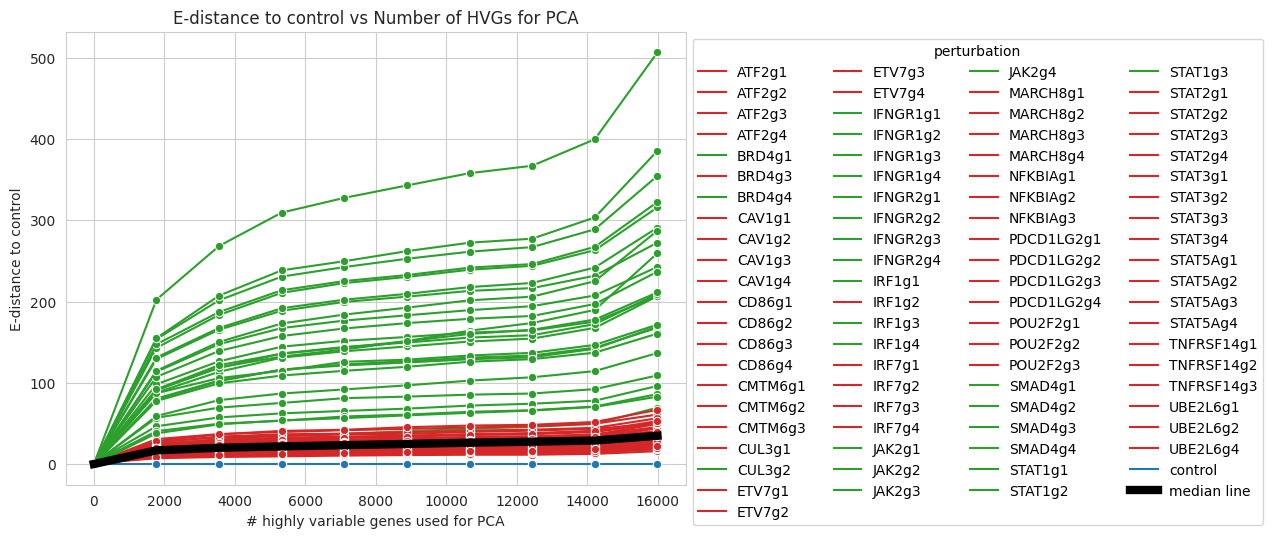

In [104]:
dataset = 'PapalexiSatija2021_eccite_RNA'
adata = sc.read(h5_files[f'tmp_data_{dataset}'])
df = test_HVGs(adata, groupby='perturbation', control='control', num=10)

100%|██████████| 10/10 [04:55<00:00, 29.57s/it]


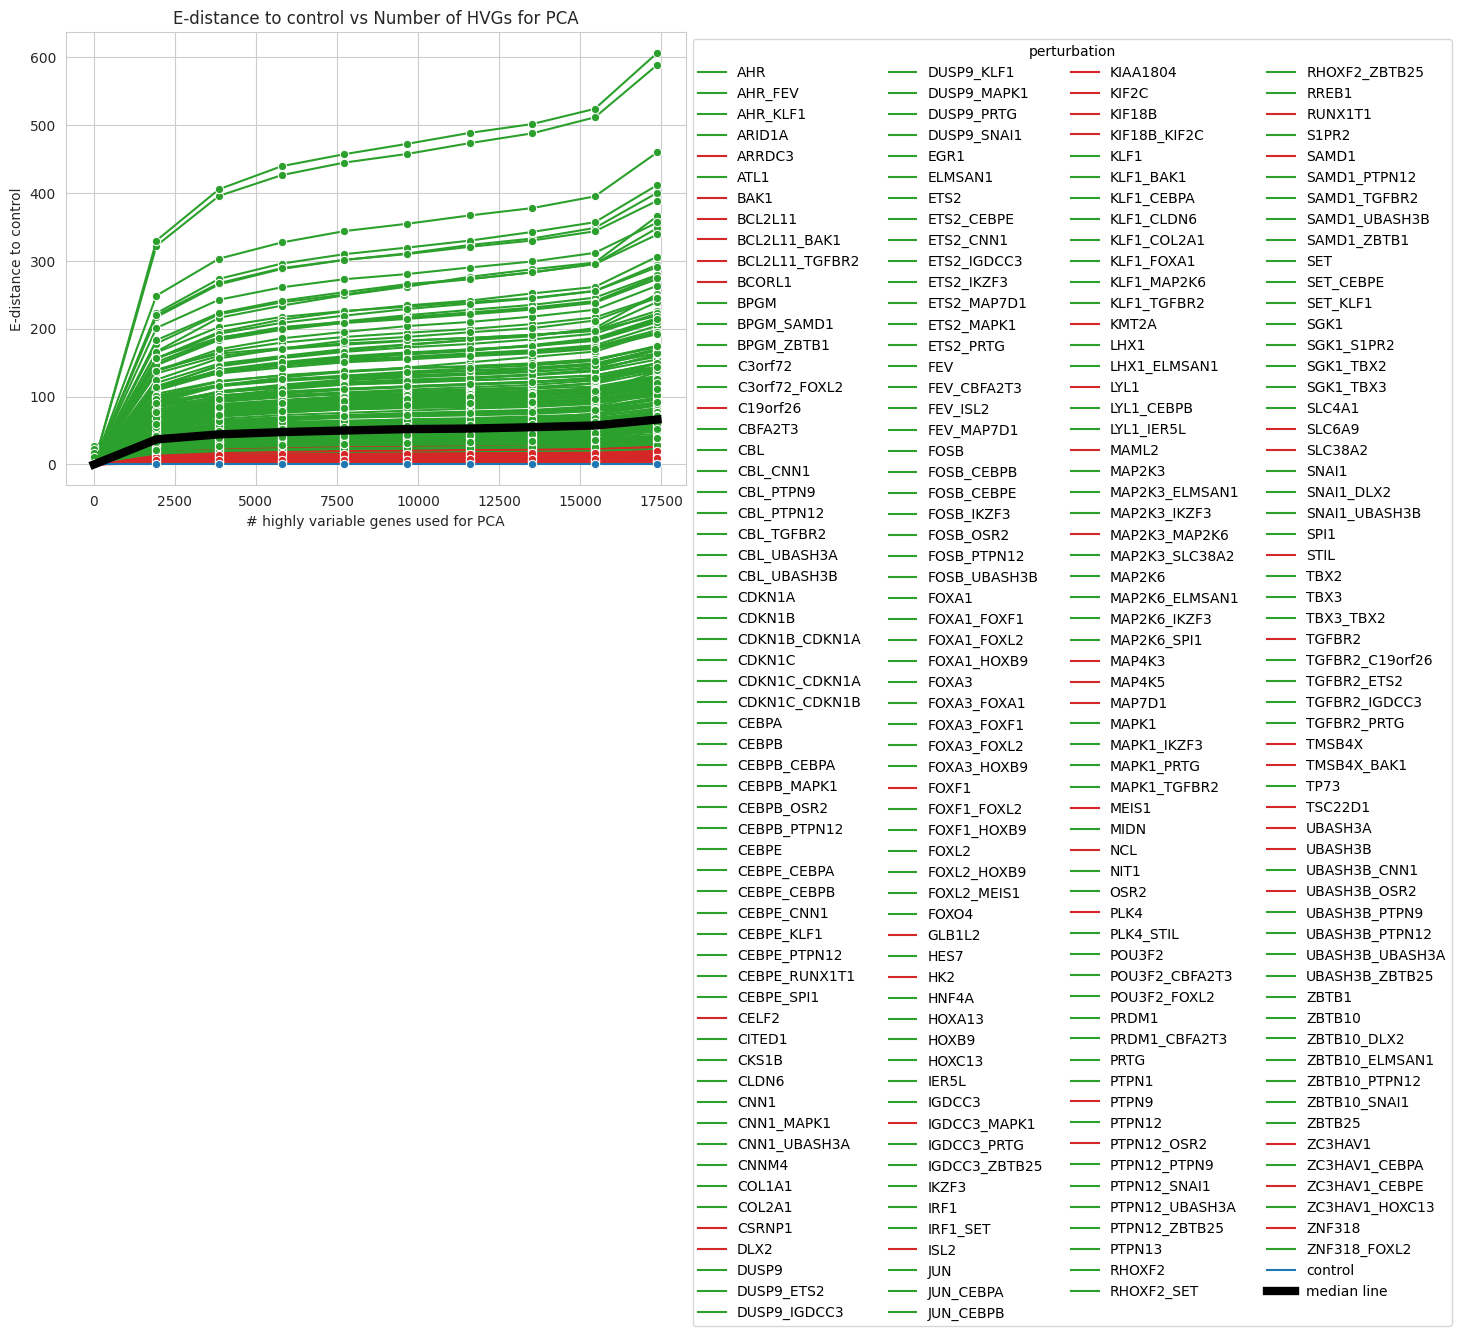

In [105]:
dataset = 'NormanWeissman2019_filtered'
adata = sc.read(h5_files[f'tmp_data_{dataset}'])
df = test_HVGs(adata, groupby='perturbation', control='control', num=10)

# Dependence on number of PCs

In [106]:
def test_nPCs(adata, groupby='perturbation', control='control', ns=[100, 50, 30, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1], show=True):
    n_max = np.max(ns)
    sc.pp.pca(adata, use_highly_variable=False, n_comps=n_max)
    eds = []
    for n in tqdm(ns):
        adata.obsm['X_pca_sub'] = adata.obsm['X_pca'][:, :int(n)]  # subset PCA to use only n first PCs
        ed = edist_to_control(adata, groupby, control, verbose=False, obsm_key='X_pca_sub')
        eds.append(ed)
    df = pd.concat(eds, axis=1).T
    df.index = np.array(ns, dtype=int)
    df.head()
    
    path = Path(f'../snakemake/tables/etest_{dataset}_tables.csv')
    if path.exists():
        et = pd.read_csv(path, index_col=0)
        palette={g: 'tab:blue' if g==control else 'tab:green' if et.loc[g, 'significant_adj'] else 'tab:red' for g in df.columns}
    else:
        palette=None
    
    with sns.axes_style('whitegrid'):
        fig, ax = pl.subplots(1, 1, figsize=(8,6), dpi=100)
    plot=sns.lineplot(data=df.stack().reset_index(), x='level_0', y=0, hue=groupby, ax=ax, marker="o", palette=palette)
    ax.set_ylabel(f'E-distance to {control}')
    ax.set_xlabel('#PCs used')
    ax.set_xscale('log')
    ax.set_title(f'E-distance to {control} vs Number of PCs used from PCA')
    med_df=df.median(1)
    ax.plot(med_df.index, med_df.values, label='median line', linewidth=6, color='black')

    h,l = plot.axes.get_legend_handles_labels()
    plot.axes.legend_.remove()
    ax.legend(h,l, ncol=4, bbox_to_anchor=(1,1), title=groupby)

    if show: pl.show()
    return df

100%|██████████| 13/13 [00:11<00:00,  1.16it/s]


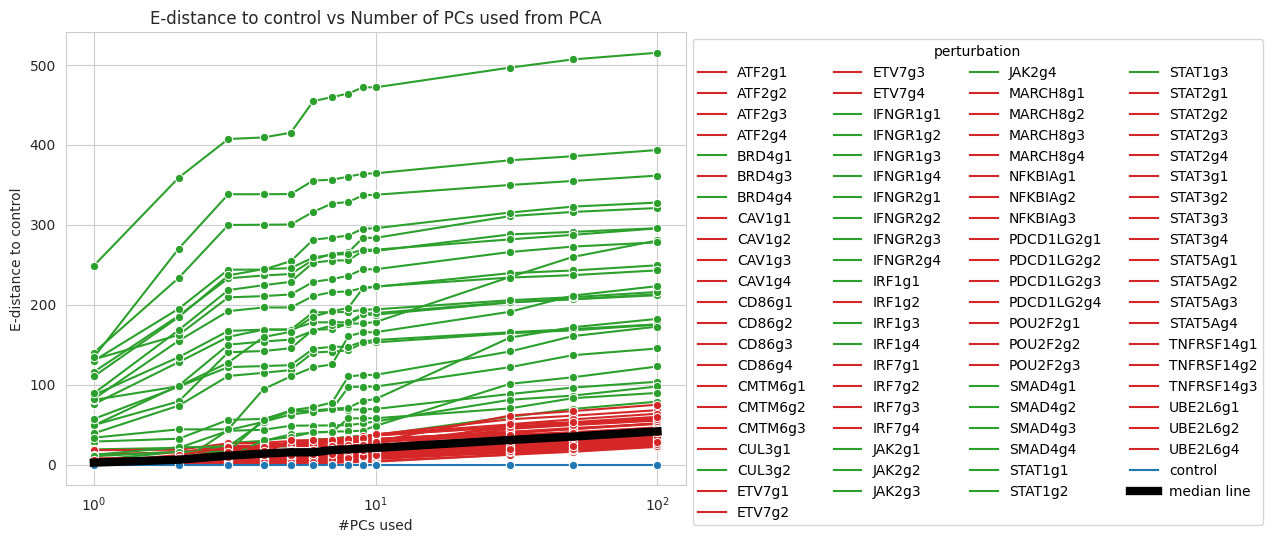

In [107]:
dataset = 'PapalexiSatija2021_eccite_RNA'
adata = sc.read(h5_files[f'tmp_data_{dataset}'])
df = test_nPCs(adata, groupby='perturbation', control='control', ns=[100, 50, 30, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1])

100%|██████████| 13/13 [00:18<00:00,  1.43s/it]


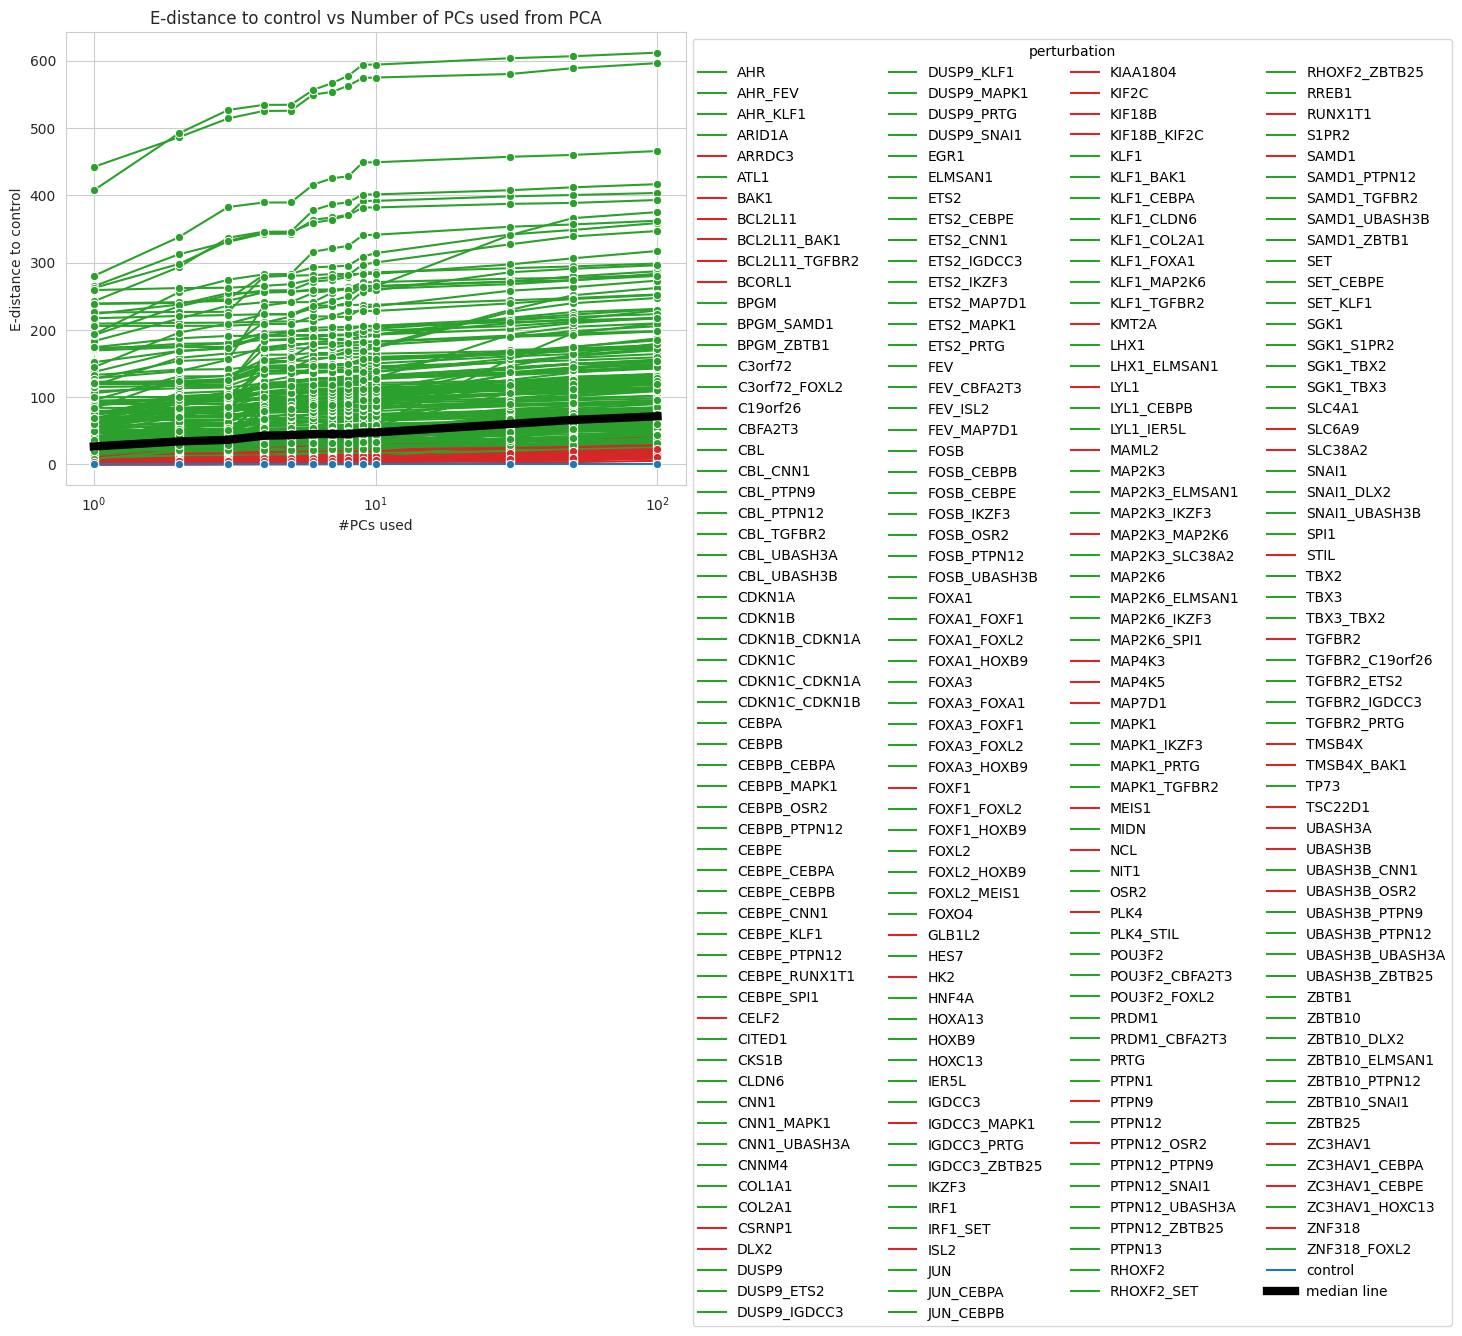

In [108]:
dataset = 'NormanWeissman2019_filtered'
adata = sc.read(h5_files[f'tmp_data_{dataset}'])
df = test_nPCs(adata, groupby='perturbation', control='control', ns=[100, 50, 30, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1])

# Dependence on number of cells (old)

In [123]:
adata = sc.read(h5_files[f'tmp_data_{dataset}'])

In [124]:
eds = []
sigs = []
deltas = []
ncells = []
ns = np.linspace(0.05, 1, num=10)
for n in tqdm(ns):
    tdata = sc.pp.subsample(adata, fraction=n, copy=True)
    sc.pp.pca(tdata, use_highly_variable=False)
    ncells.append(tdata.obs[groupby].value_counts())
    
    # EDITST
    deltas_to_c = onesided_pca_distances(tdata, obs_key=groupby, control=control, verbose=False)
    sigmas = self_pca_distances(tdata, groupby, verbose=False)
    # derive basic statistics
    ed = 2 * deltas_to_c - sigmas - sigmas.loc[control]
    eds.append(ed)
    sigs.append(sigmas)
    deltas.append(deltas_to_c)

100%|██████████| 10/10 [01:45<00:00, 10.58s/it]


In [125]:
df = pd.concat(eds, axis=1).T
df.index = np.array(ns)
df.head()

perturbation       ETV7g4      STAT1g2  PDCD1LG2g1    IFNGR2g1       BRD4g4  \
0.050000      1948.632944  2247.299677  149.452022  955.510272  2011.133594   
0.155556      -199.862934  -564.264536 -824.308189 -374.792057  -721.220775   
0.261111      -495.312575  -297.428599 -391.156559  -64.838378  -393.606341   
0.366667      -195.303341   101.411251 -505.275431  -80.365022   -70.029624   
0.472222       -95.641060   -44.663715 -393.816440 -160.673169  -182.799944   

perturbation     STAT5Ag3      CAV1g3       JAK2g4       JAK2g1     IFNGR1g3  \
0.050000      2712.112961  481.197630  7599.386465  1463.987325  2053.701011   
0.155556      -620.316448 -947.929327   317.502550  -484.916904  -381.815171   
0.261111      -590.498705 -627.777957   107.787726  -656.891698   114.947691   
0.366667      -223.758343 -432.705319  -118.108149  -316.890752    68.934577   
0.472222      -218.107297 -326.876097   -25.215957  -167.485257   -44.934992   

perturbation  ...      CD86g1      ETV7g2    NFKBIAg1   PDCD1LG2g4  \
0.050000      ... -712.118768 -505.216810 -466.543348   613.230103   
0.155556      ... -704.347579 -759.814388 -857.095369 -1156.274482   
0.261111      ... -113.271793 -652.177967 -673.540177  -739.143698   
0.366667      ... -246.389888 -250.473272 -164.555049  -419.766746   
0.472222      ...  -33.907507 -190.122480 -239.906015  -363.527742   

perturbation       IRF7g2      IRF1g2    STAT5Ag1     UBE2L6g2    IFNGR2g2  \
0.050000              NaN         NaN         NaN          NaN         NaN   
0.155556     -1140.475495 -327.796155 -852.418195 -1061.027105 -960.229984   
0.261111      -902.925669 -391.020243 -809.582178  -793.876913 -218.827958   
0.366667      -512.627821 -156.137937 -611.427494  -712.833690 -211.752833   
0.472222      -368.863106 -254.297268 -539.681310  -529.979273   33.100196   

perturbation     NFKBIAg2  
0.050000              NaN  
0.155556     -1131.836085  
0.261111     -1053.864529  
0.366667      -633.311379  
0.472222      -273.384340  

[5 rows x 84 columns]

In [136]:
df_d = pd.concat(deltas, axis=1).T
df_d.index = np.array(ns, dtype=float)
df_s = pd.concat(sigs, axis=1).T
df_s.index = np.array(ns, dtype=float)

In [137]:
path = Path(f'../snakemake/tables/etest_{dataset}_tables.csv')
if path.exists():
    et = pd.read_csv(path, index_col=0)
    palette={g: 'tab:blue' if g==control else 'tab:green' if et.loc[g, 'significant_adj'] else 'tab:red' for g in df.columns}
else:
    palette=None

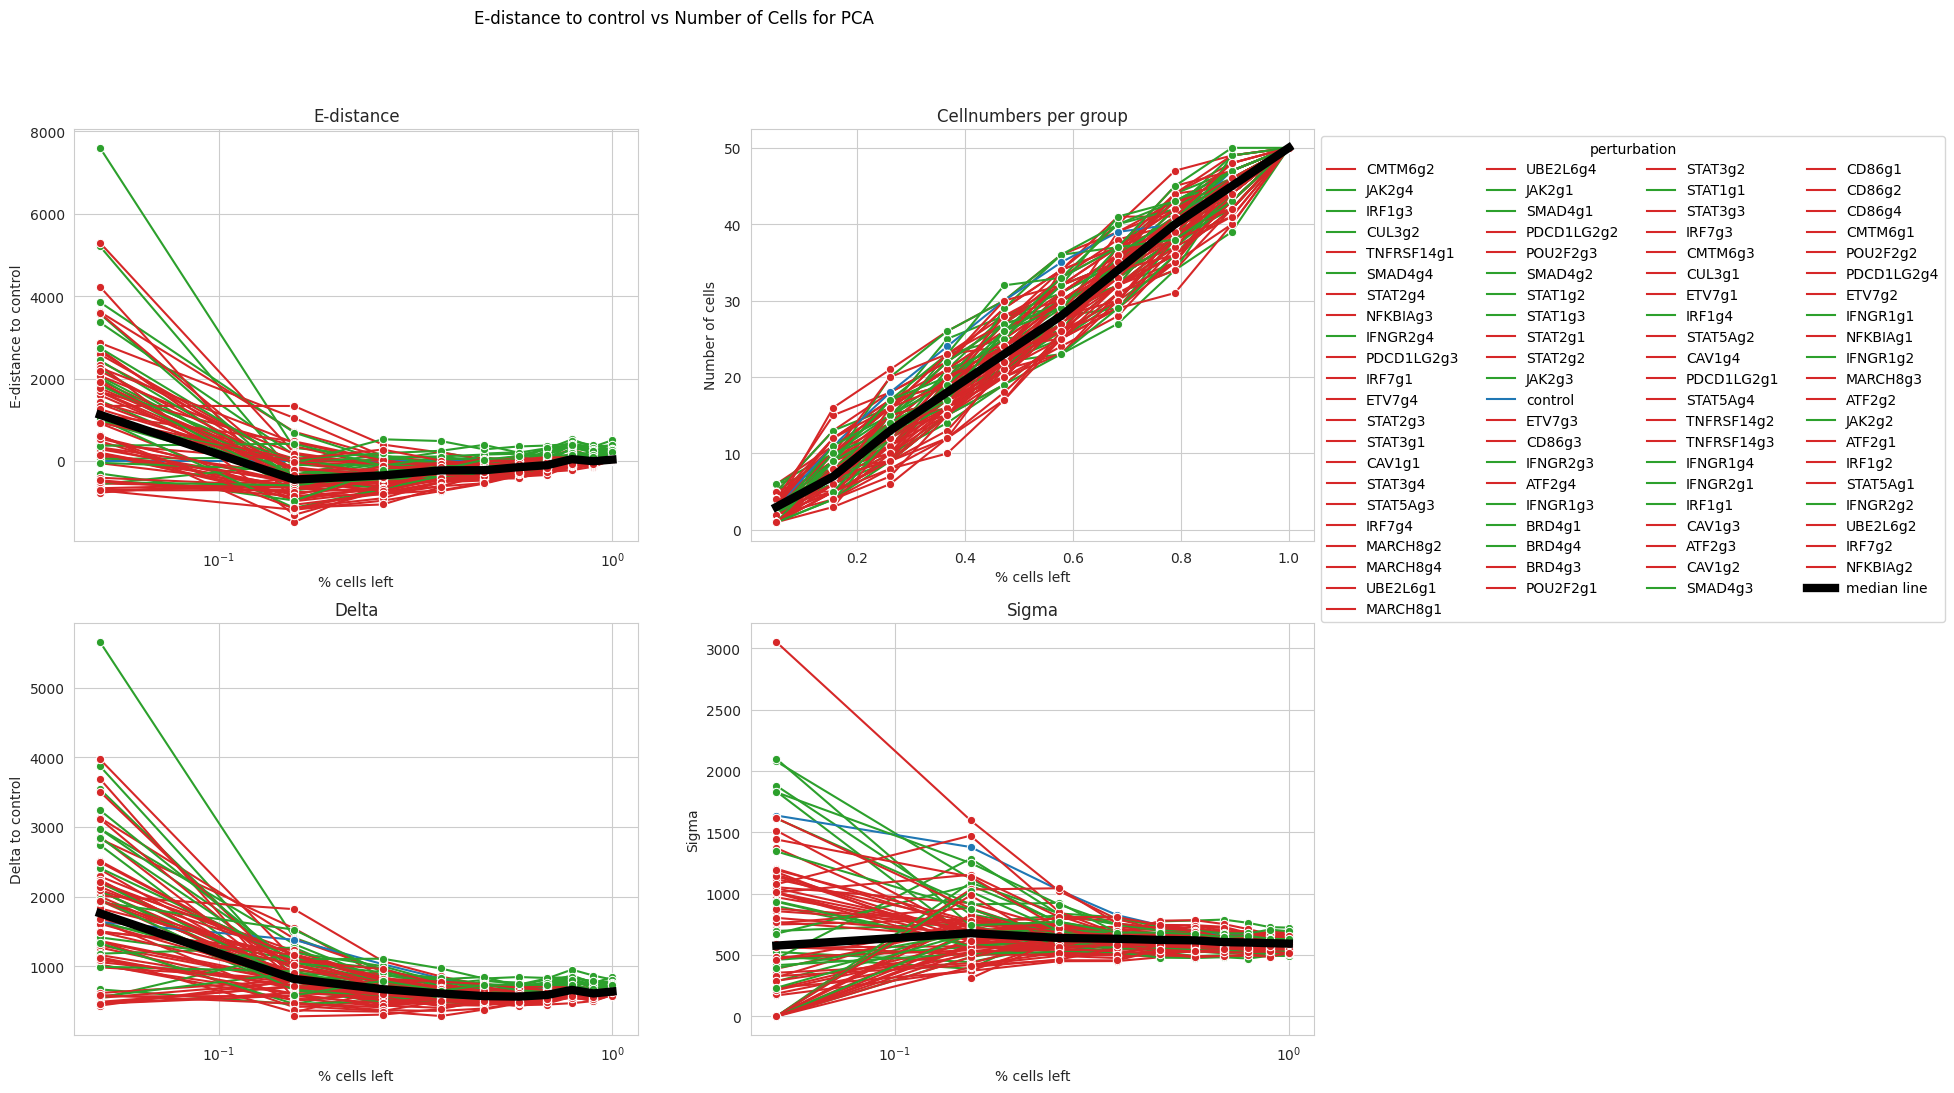

In [140]:
with sns.axes_style('whitegrid'):
    fig, axs = pl.subplots(2, 2, figsize=(8*2,6*2), dpi=100)
lineplot_kwargs = dict(x='level_0', y=0, marker="o", palette=palette)
ax=axs[0,0]
sns.lineplot(data=df.stack().reset_index(), hue=groupby, ax=ax, legend=ax==axs[0,-1], **lineplot_kwargs)
ax.set_ylabel(f'E-distance to {control}')
ax.set_xlabel('% cells left')
ax.set_title('E-distance')
ax.set_xscale('log')
med_df=df.median(1)
ax.plot(med_df.index, med_df.values, label='median line', linewidth=6, color='black')

ax=axs[0,1]
ndf = pd.DataFrame(ncells, index=ns)
plot=sns.lineplot(data=ndf.stack().reset_index(), hue='level_1', ax=ax, legend=ax==axs[0,-1], **lineplot_kwargs)
ax.set_ylabel('Number of cells')
ax.set_xlabel('% cells left')
ax.set_title('Cellnumbers per group')
med_ndf=ndf.median(1)
ax.plot(med_ndf.index, med_ndf.values, label='median line', linewidth=6, color='black')
h,l = plot.axes.get_legend_handles_labels()
plot.axes.legend_.remove()
ax.legend(h,l, ncol=4, bbox_to_anchor=(1,1), title=groupby)

ax=axs[1,0]
plot=sns.lineplot(data=df_d.stack().reset_index(), hue=groupby, ax=ax, legend=ax==axs[0,-1], **lineplot_kwargs)
ax.set_ylabel(f'Delta to {control}')
ax.set_xlabel('% cells left')
ax.set_title('Delta')
ax.set_xscale('log')
med_df=df_d.median(1)
ax.plot(med_df.index, med_df.values, label='median line', linewidth=6, color='black')

ax=axs[1,1]
plot=sns.lineplot(data=df_s.stack().reset_index(), hue=groupby, ax=ax, legend=ax==axs[0,-1], **lineplot_kwargs)
ax.set_ylabel(f'Sigma')
ax.set_xlabel('% cells left')
ax.set_title('Sigma')
ax.set_xscale('log')
med_df=df_s.median(1)
ax.plot(med_df.index, med_df.values, label='median line', linewidth=6, color='black')

pl.suptitle(f'E-distance to {control} vs Number of Cells for PCA')

pl.show()

# Dependence on counts (CURRENTLY WRONG!)

In [55]:
sdf = pd.read_csv(f'../snakemake/tables/effect_of_ncells_{dataset}_tables.csv', index_col=0)
sdf

n perturbation     edist  pvalue  significant  pvalue_adj  \
0    0.002796       ATF2g1  0.026491    0.53        False    1.000000   
1    0.002796       ATF2g2  0.034430    0.46        False    1.000000   
2    0.002796       ATF2g3  0.030162    0.32        False    1.000000   
3    0.002796       ATF2g4  0.029246    0.39        False    1.000000   
4    0.002796       BRD4g1  0.041416    0.03         True    0.898169   
..        ...          ...       ...     ...          ...         ...   
919  1.000000   TNFRSF14g3  6.468941    0.42        False    0.999384   
920  1.000000     UBE2L6g1  5.029889    0.65        False    0.999784   
921  1.000000     UBE2L6g2  7.335453    0.15        False    0.997554   
922  1.000000     UBE2L6g4  9.384714    0.06        False    0.934291   
923  1.000000      control  0.000000    0.00         True    0.000000   

    significant_adj       delta       sigma  ncells significant_adj_new  
0             False    0.658632    0.590556      50               False  
1             False    0.840541    0.946435      50               False  
2             False    0.680282    0.630183      50               False  
3             False    0.674839    0.620214      50               False  
4             False    0.775598    0.809563      50        False (lost)  
..              ...         ...         ...     ...                 ...  
919           False  151.678723  157.348312      50               False  
920           False  150.862050  157.154017      50               False  
921           False  147.937157  148.998668      50               False  
922           False  156.298264  163.671620      50               False  
923         control  139.540193  139.540193      50             control  

[924 rows x 11 columns]

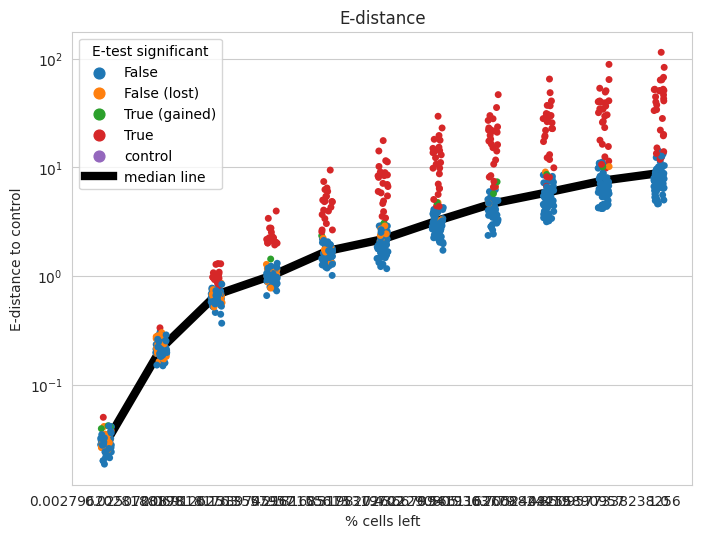

In [56]:
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=(8,6), dpi=100)
ax.set_yscale('log')
sns.stripplot(data=sdf, x='n', y='edist', hue='significant_adj_new')
ax.set_ylabel(f'E-distance to {control}')
ax.set_xlabel('% cells left')
ax.set_title('E-distance')
med_df=sdf.groupby('n').median()
ax.plot(np.arange(len(med_df)), med_df.edist, label='median line', linewidth=6, color='black')
ax.legend(title='E-test significant')
pl.show()

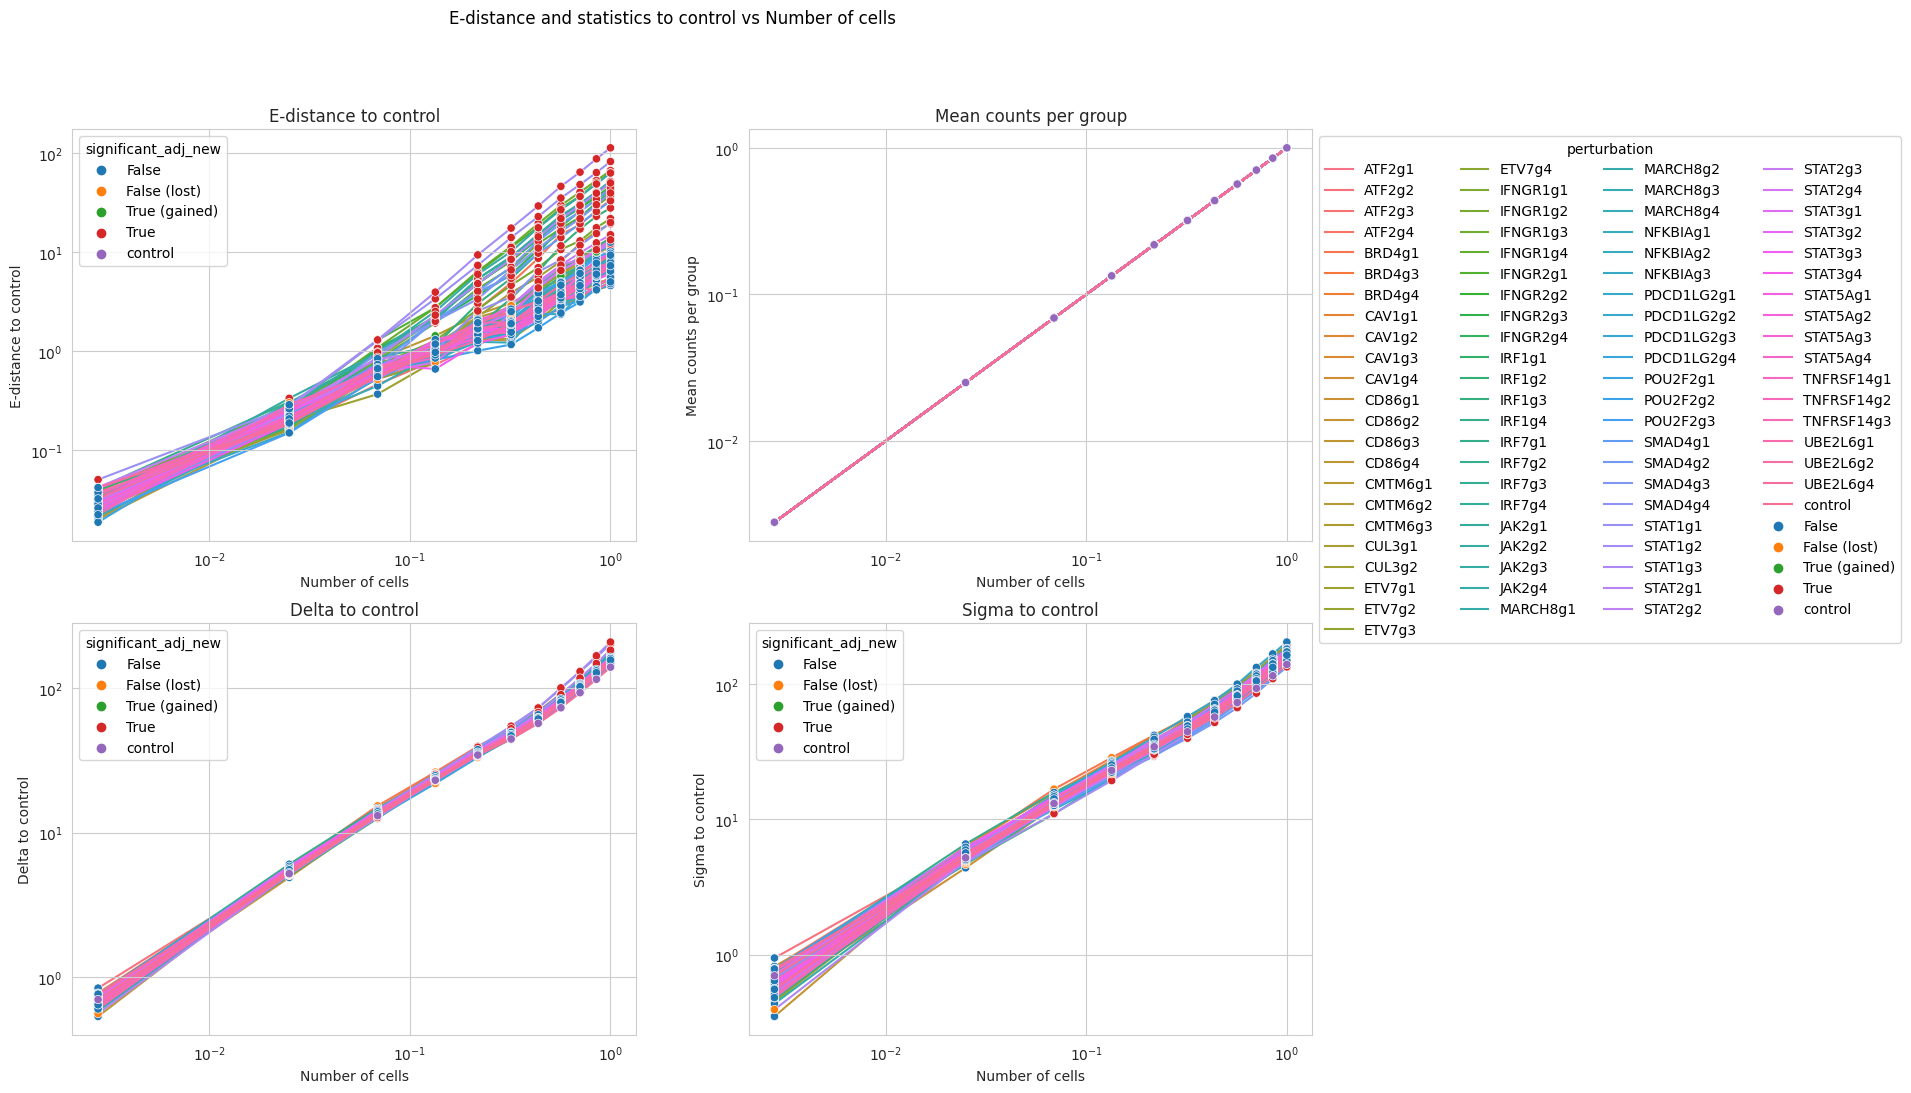

In [62]:
x = 'n'
xlabel = 'Number of cells'

with sns.axes_style('whitegrid'):
    fig, axs = pl.subplots(2, 2, figsize=(8*2,6*2), dpi=100)
lineplot_kwargs = dict(hue=groupby, color='grey', x=x, zorder=-1)
scatterplot_kwargs = dict(hue='significant_adj_new', marker="o", x=x)

for y, ax, title in zip(['edist', 'n', 'delta', 'sigma'],
                        np.ravel(axs),
                        [f'E-distance to {control}', 'Mean counts per group', f'Delta to {control}', f'Sigma to {control}']
                       ):
    plot=sns.lineplot(data=sdf, ax=ax, y=y, legend=ax==axs[0,-1], **lineplot_kwargs)
    sns.scatterplot(data=sdf, ax=ax, y=y, **scatterplot_kwargs)
    ax.set_ylabel(title)
    ax.set_title(title)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(xlabel)
    
    # merge tight legend
    if y=='n':
        h,l = plot.axes.get_legend_handles_labels()
        plot.axes.legend_.remove()
        ax.legend(h,l, ncol=4, bbox_to_anchor=(1,1), title=groupby)

pl.suptitle(f'E-distance and statistics to {control} vs {xlabel}')

pl.show()

# Dependence on counts (with testing)

In [63]:
sdf = pd.read_csv(f'../snakemake/tables/effect_of_ncounts_{dataset}_tables.csv', index_col=0)
sdf.head()

n perturbation     edist  pvalue  significant  pvalue_adj  \
0  0.002796       ATF2g1  0.099285    0.18        False    0.999985   
1  0.002796       ATF2g2  0.105300    0.23        False    0.999998   
2  0.002796       ATF2g3  0.089069    0.74        False    1.000000   
3  0.002796       ATF2g4  0.105892    0.16        False    0.999966   
4  0.002796       BRD4g1  0.170978    0.00         True    0.000000   

  significant_adj     delta     sigma  ncounts significant_adj_new  
0           False  2.151487  2.286627    10.20               False  
1           False  2.162362  2.302362     9.42               False  
2           False  2.666744  3.327357     7.32        False (lost)  
3           False  1.979706  2.017263    10.16               False  
4            True  2.364256  2.736973     7.38                True

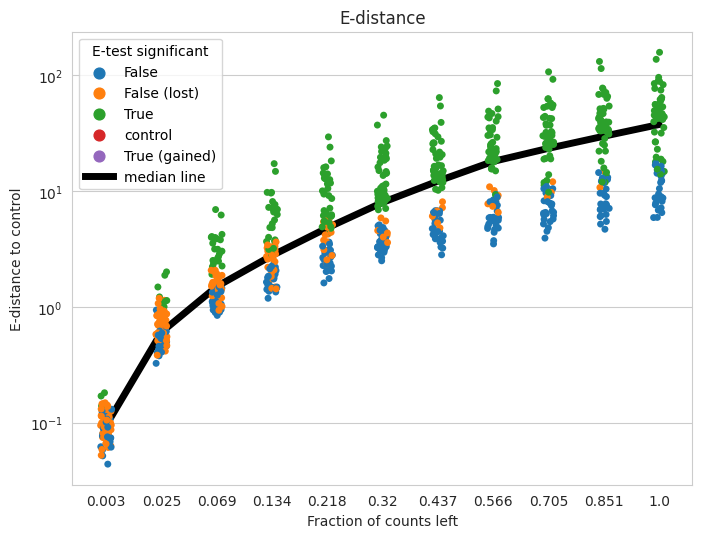

In [76]:
from matplotlib.ticker import StrMethodFormatter

with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=(8,6), dpi=100)
ax.set_yscale('log')
sns.stripplot(data=sdf, x='n', y='edist', hue='significant_adj_new')
ax.set_ylabel(f'E-distance to {control}')
ax.set_xlabel('Fraction of counts left')
ax.set_title('E-distance')
med_df=sdf.groupby('n').median()
ax.plot(np.arange(len(med_df)), med_df.edist, label='median line', linewidth=5, color='black')
ax.legend(title='E-test significant')
ax.set_xticklabels(np.round(sdf.n.unique(), 3))
pl.show()

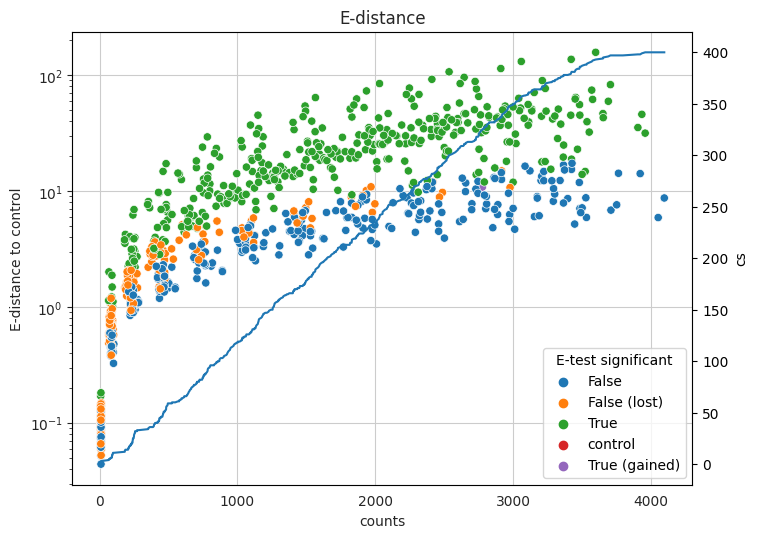

In [83]:
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=(8,6), dpi=100)
ax.set_yscale('log')
sns.scatterplot(data=sdf, x='ncounts', y='edist', hue='significant_adj_new')
ax.set_ylabel(f'E-distance to {control}')
ax.set_xlabel('counts')
ax.set_title('E-distance')
#med_df=sdf.groupby('ncounts').median()
#ax.plot(med_df.index, med_df.edist, label='median line', linewidth=6, color='black')
ax.legend(title='E-test significant')

cs = np.cumsum(sdf.sort_values('ncounts').significant_adj=='True')
ax2=ax.twinx()
sdf['cs'] = cs
sns.lineplot(data=sdf, x='ncounts', y='cs')

pl.show()

In [114]:
sdf['bin'] = pd.cut(sdf.ncounts, 10, labels=False)
cts = sdf[['significant_adj_new', 'bin']].value_counts(sort=False, dropna=False)

In [115]:
(cts['False'] + cts['False (lost)']) / cts.groupby('bin').sum()

bin
0    0.842491
1    0.592857
2    0.408602
3    0.416667
4    0.423077
5    0.364865
6    0.323529
7    0.350000
8         NaN
9         NaN
dtype: float64

In [116]:
cts

significant_adj_new  bin
False                0       85
                     1       52
                     2       28
                     3       27
                     4       26
                     5       26
                     6       20
                     7       19
                     8       18
                     9        6
False (lost)         0      145
                     1       31
                     2       10
                     3        8
                     4        7
                     5        1
                     6        2
                     7        2
True                 0       40
                     1       56
                     2       53
                     3       49
                     4       44
                     5       46
                     6       44
                     7       38
                     8       24
                     9        5
True (gained)        6        1
control              0        3
               

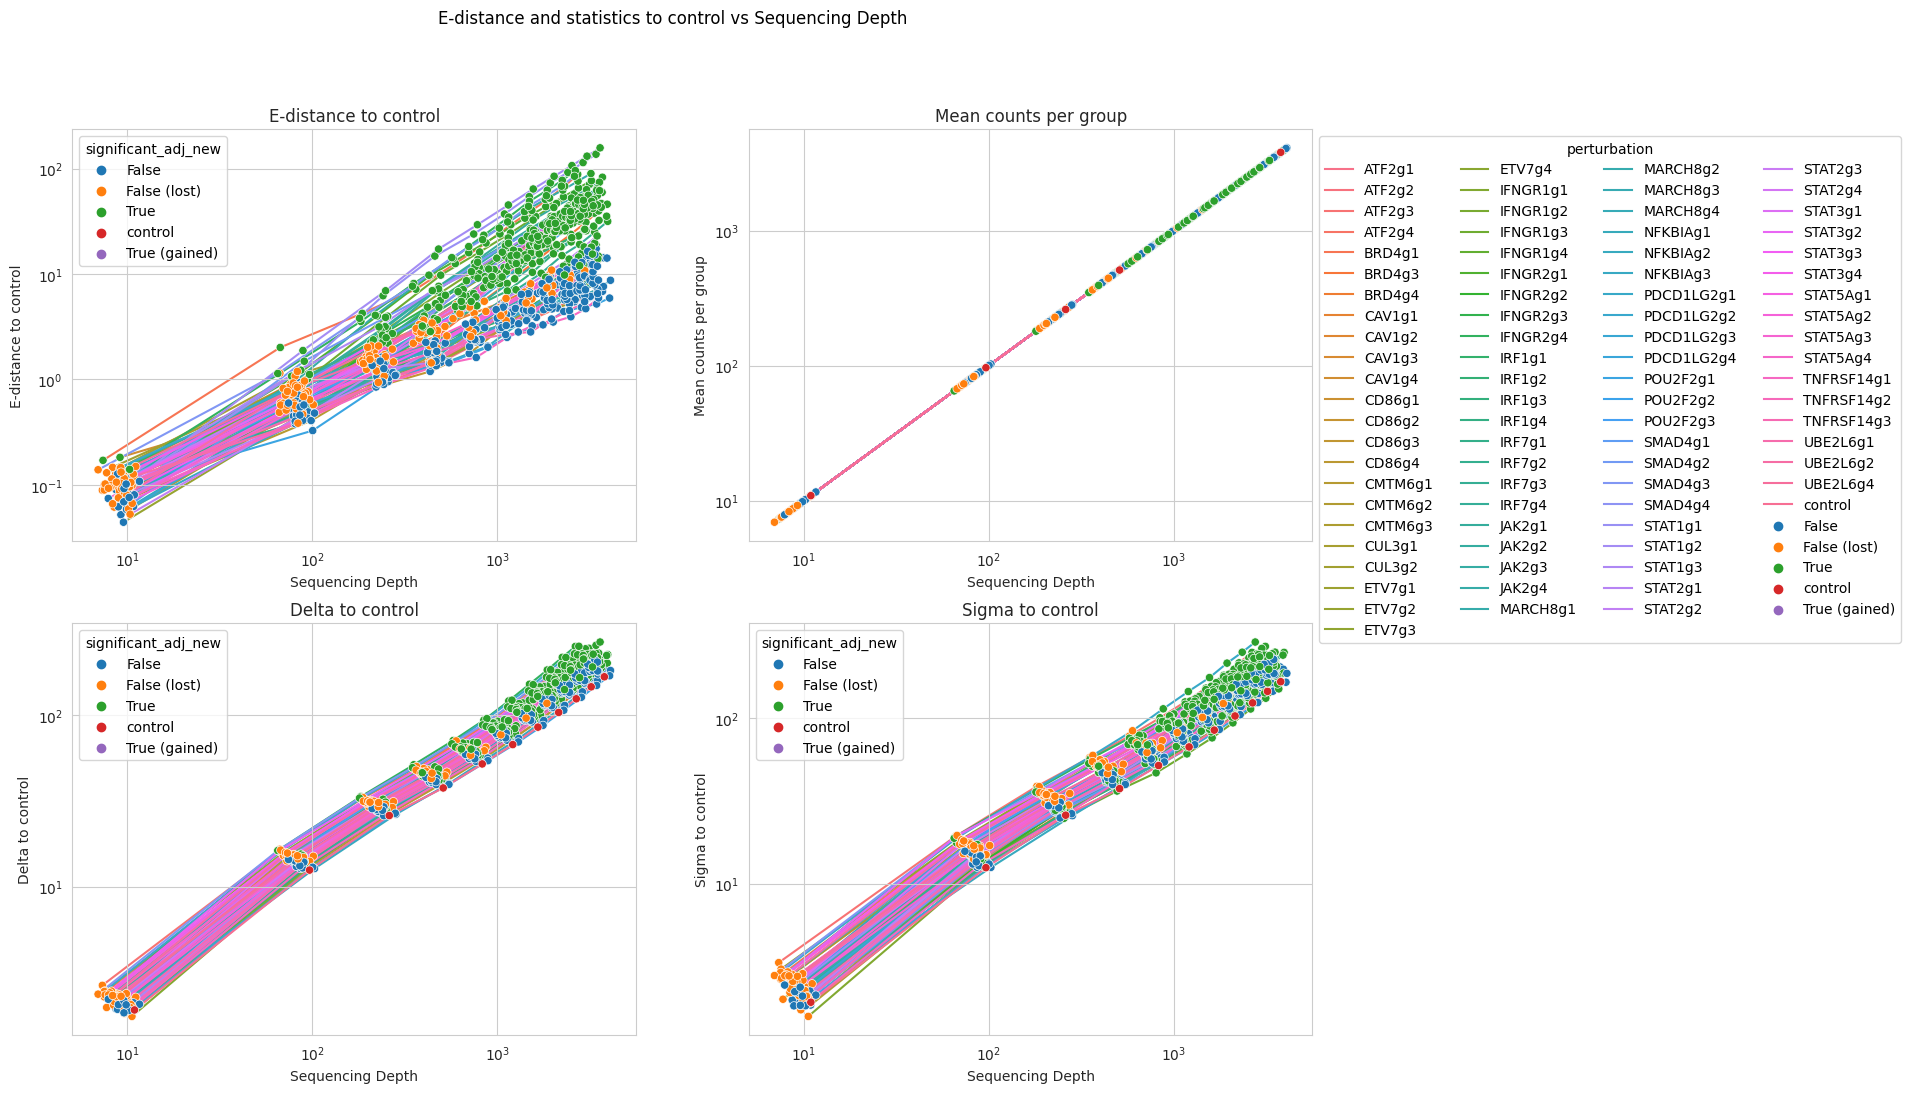

In [54]:
x = 'ncounts'
xlabel = 'Sequencing Depth'

with sns.axes_style('whitegrid'):
    fig, axs = pl.subplots(2, 2, figsize=(8*2,6*2), dpi=100)
lineplot_kwargs = dict(hue=groupby, color='grey', x=x, zorder=-1)
scatterplot_kwargs = dict(hue='significant_adj_new', marker="o", x=x)

for y, ax, title in zip(['edist', 'ncounts', 'delta', 'sigma'],
                        np.ravel(axs),
                        [f'E-distance to {control}', 'Mean counts per group', f'Delta to {control}', f'Sigma to {control}']
                       ):
    plot=sns.lineplot(data=sdf, ax=ax, y=y, legend=ax==axs[0,-1], **lineplot_kwargs)
    sns.scatterplot(data=sdf, ax=ax, y=y, **scatterplot_kwargs)
    ax.set_ylabel(title)
    ax.set_title(title)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(xlabel)
    
    # merge tight legend
    if y=='ncounts':
        h,l = plot.axes.get_legend_handles_labels()
        plot.axes.legend_.remove()
        ax.legend(h,l, ncol=4, bbox_to_anchor=(1,1), title=groupby)

pl.suptitle(f'E-distance and statistics to {control} vs {xlabel}')

pl.show()

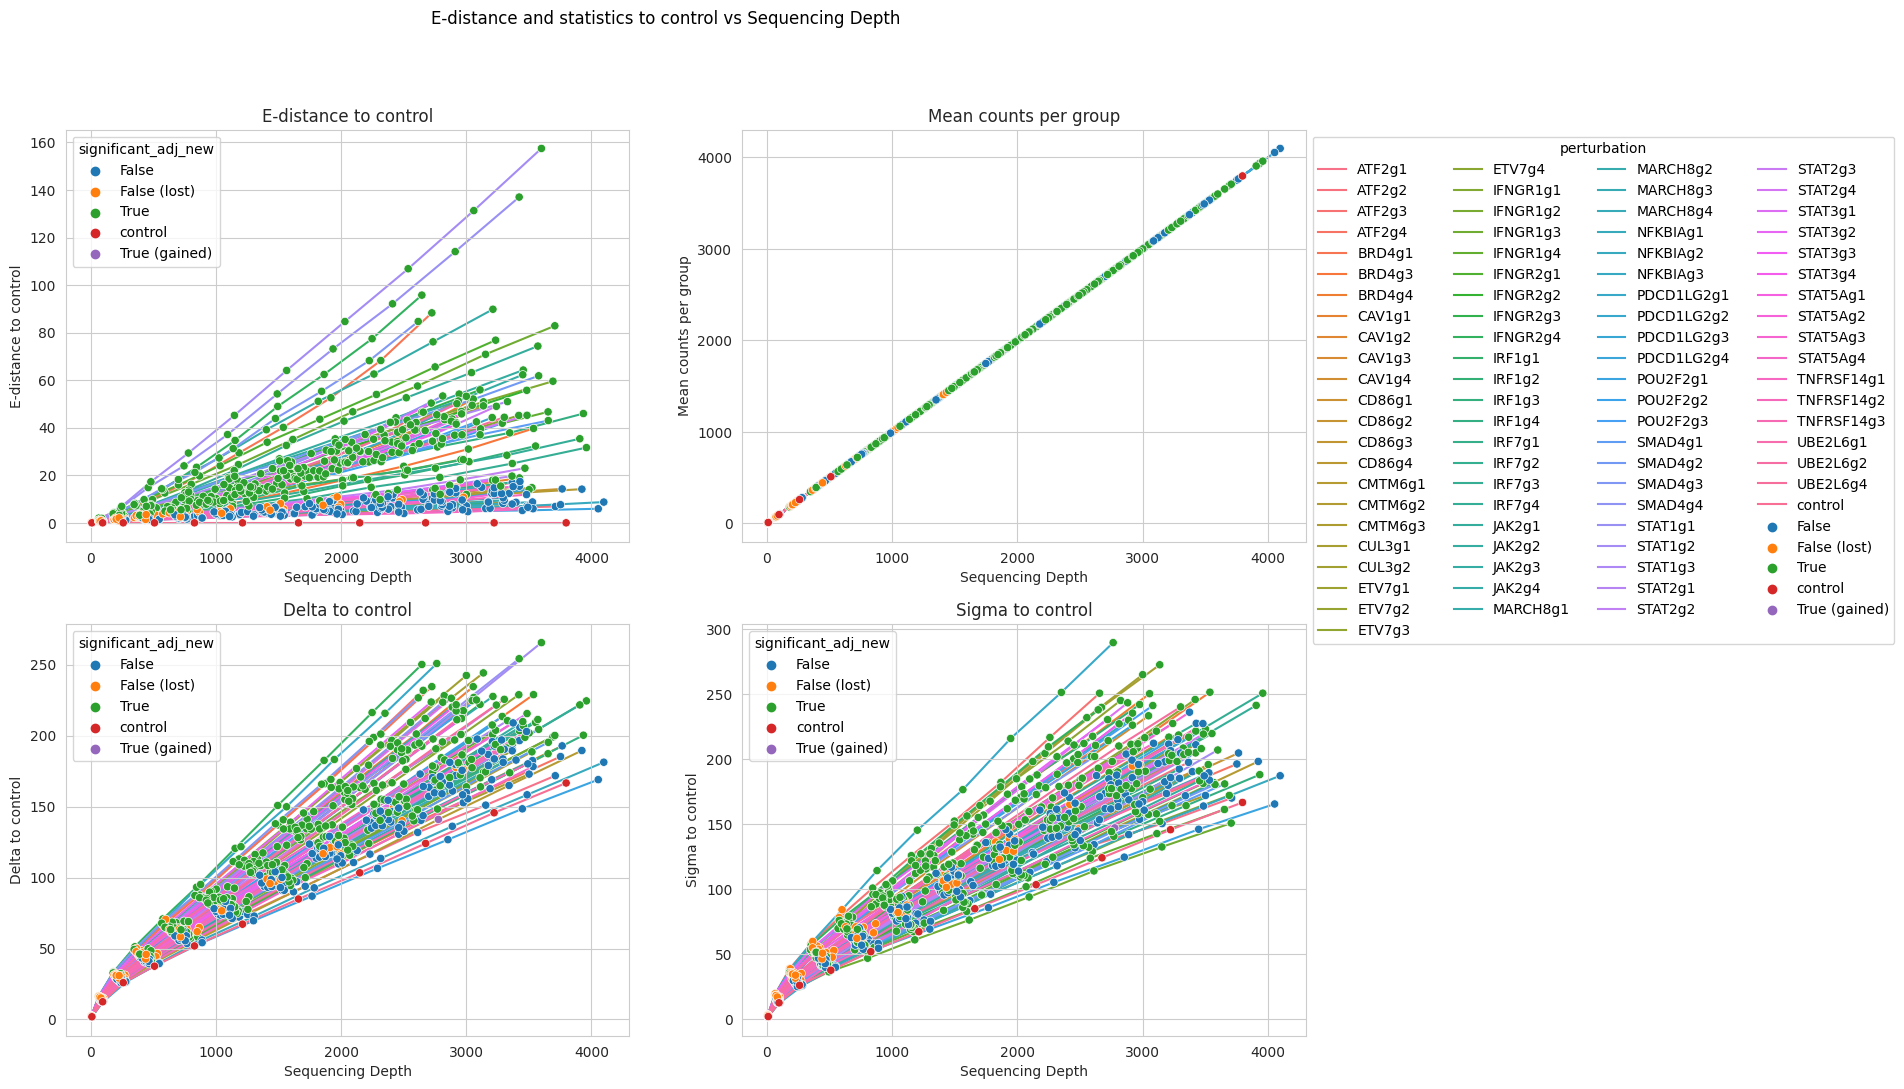

In [117]:
x = 'ncounts'
xlabel = 'Sequencing Depth'

with sns.axes_style('whitegrid'):
    fig, axs = pl.subplots(2, 2, figsize=(8*2,6*2), dpi=100)
lineplot_kwargs = dict(hue=groupby, color='grey', x=x, zorder=-1)
scatterplot_kwargs = dict(hue='significant_adj_new', marker="o", x=x)

for y, ax, title in zip(['edist', 'ncounts', 'delta', 'sigma'],
                        np.ravel(axs),
                        [f'E-distance to {control}', 'Mean counts per group', f'Delta to {control}', f'Sigma to {control}']
                       ):
    plot=sns.lineplot(data=sdf, ax=ax, y=y, legend=ax==axs[0,-1], **lineplot_kwargs)
    sns.scatterplot(data=sdf, ax=ax, y=y, **scatterplot_kwargs)
    ax.set_ylabel(title)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    
    # merge tight legend
    if y=='ncounts':
        h,l = plot.axes.get_legend_handles_labels()
        plot.axes.legend_.remove()
        ax.legend(h,l, ncol=4, bbox_to_anchor=(1,1), title=groupby)

pl.suptitle(f'E-distance and statistics to {control} vs {xlabel}')

pl.show()